<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/Kinetic_Inductance_Scatterplot_for_SC_Metals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scatterplots for Kinetic Inductances Across Different Superconducting Metals

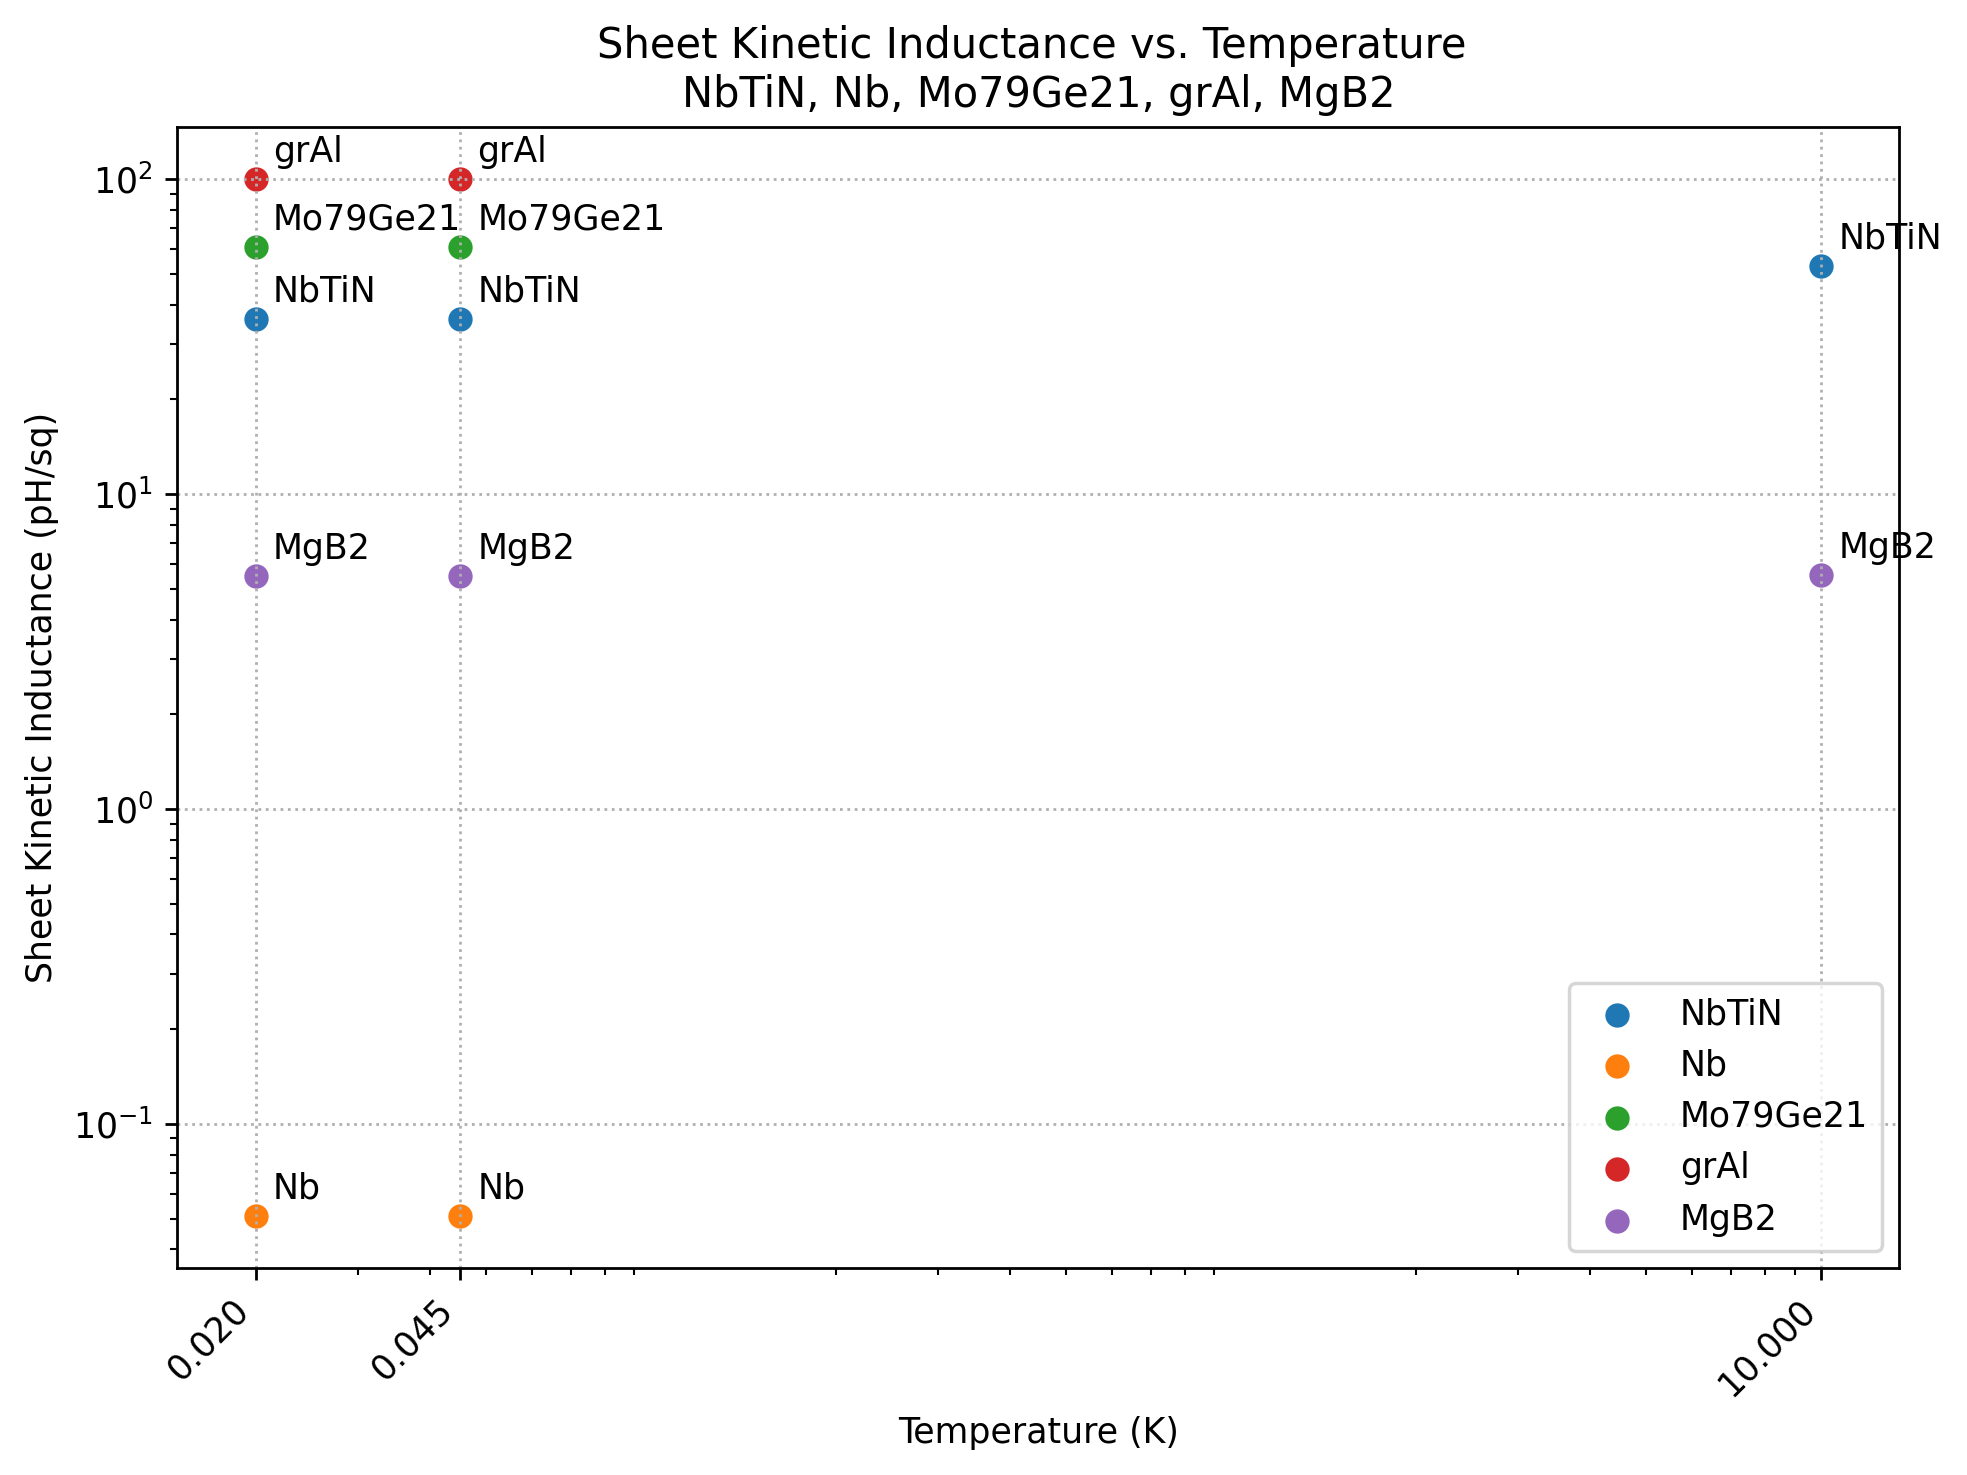

In [8]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 250

def delta_ratio_BCS(T, Tc):
    if T <= 0:
        return 1.0
    if T >= Tc:
        return np.nan
    x = 1.74 * math.sqrt(Tc / T - 1.0)
    return math.tanh(x)

def Ls_T_from_Ls0(Ls0, T, Tc):
    if T >= Tc:
        return np.nan
    delta0_over_kBT = 1.764 * Tc / T
    ratio = delta_ratio_BCS(T, Tc)
    if ratio <= 0 or np.isnan(ratio):
        return np.nan
    x = 0.5 * delta0_over_kBT * ratio
    tanh_term = math.tanh(x)
    if tanh_term == 0:
        return np.nan
    return Ls0 * (1.0 / (ratio * tanh_term))

materials = {
    "NbTiN": {"Ls0_pHsq": 36.0, "Tc_K": 15.0},
    "Nb": {"Ls0_pHsq": 0.051, "Tc_K": 9.2},
    "Mo79Ge21": {"Ls0_pHsq": 61.0, "Tc_K": 4.4},
    "grAl": {"Ls0_pHsq": 100.0, "Tc_K": 2.2},
    "MgB2": {"Ls0_pHsq": 5.5, "Tc_K": 39.0},
}
temperatures_K = [0.020, 0.045, 10]

rows = []
for mat, params in materials.items():
    Ls0 = params["Ls0_pHsq"]
    Tc = params["Tc_K"]
    for T in temperatures_K:
        Ls_T = Ls_T_from_Ls0(Ls0, T, Tc)
        rows.append({
            "Material": mat,
            "Temperature_K": T,
            "Sheet_Kinetic_Inductance_pH_per_sq": None if np.isnan(Ls_T) else Ls_T,
            "Assumed_Tc_K": Tc,
            "State": "superconducting" if (not np.isnan(Ls_T)) else "normal (not superconducting at this T)"
        })

df = pd.DataFrame(rows)

plt.figure(figsize=(8, 6))
for mat in materials.keys():
    sub = df[(df["Material"] == mat) & (df["State"].str.startswith("superconducting"))]
    if len(sub) == 0:
        continue
    plt.scatter(sub["Temperature_K"], sub["Sheet_Kinetic_Inductance_pH_per_sq"], label=mat)
    for _, r in sub.iterrows():
        plt.annotate(mat, (r["Temperature_K"], r["Sheet_Kinetic_Inductance_pH_per_sq"]), textcoords="offset points", xytext=(5, 5))

plt.xscale("log")
plt.yscale("log")

xticks = [0.020, 0.045, 10]
xticklabels = [f"{x:.3f}" for x in xticks]
plt.xticks(xticks, xticklabels, rotation=45, ha="right")

plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Kinetic Inductance (pH/sq)")
plt.title("Sheet Kinetic Inductance vs. Temperature \nNbTiN, Nb, Mo79Ge21, grAl, MgB2")
plt.grid('true', linestyle = ':')
plt.legend()
plt.tight_layout()

# out_path = "/content/kinetic_inductance_scatter_decimalK.png"
# plt.savefig(out_path, dpi=180)
# print(out_path)